In [1]:
import logging
import sys

from fitter import Fitter
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.ensemble import RandomForestRegressor

sys.path.append('..')
from read_data import read_airbnb_df, read_amenities_df

logging.getLogger().setLevel(logging.ERROR)

In [2]:
df = read_airbnb_df()
df_am = read_amenities_df()
df_concat = pd.concat([df, df_am], axis=1)
df = df_concat[df_concat["number_of_reviews"] >= 10]

In [3]:
X = df.drop(columns=["review_scores_rating", "property_type",
                        "city", "room_type", "host_since"])
y = df["review_scores_rating"]

In [4]:
regressor = RandomForestRegressor(random_state=0, n_jobs=-1)
regressor.fit(X, y)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [5]:
sampleDf = X.sample(n=1000, random_state=0, ignore_index=True)
sampleDf

,log_price,accommodates,bathrooms,cleaning_fee,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,number_of_reviews,...,First_aid_kit,Cable_TV,Free_parking_on_premises,24_hour_check_in,Lock_on_bedroom_door,Buzzer_wireless_intercom,Safety_card,Self_Check_In,Elevator,Pets_allowed
0,5.278115,6,2.0,True,True,False,True,34.104210,-118.338478,41,...,False,True,True,True,False,False,False,True,False,False
1,4.605170,2,1.0,True,True,False,False,33.959616,-118.426475,24,...,False,False,False,False,True,False,False,False,False,True
2,3.912023,2,1.0,True,True,True,True,34.041666,-118.287186,12,...,True,True,False,False,True,False,False,False,False,False
3,4.174387,2,1.0,True,True,True,True,40.687573,-73.930318,36,...,False,False,False,True,False,False,False,False,False,True
4,4.787492,3,1.0,True,True,True,False,34.046817,-118.249758,13,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4.653960,2,1.0,True,True,True,True,40.795102,-73.947155,53,...,False,False,False,False,False,True,False,False,True,False
996,4.094345,2,1.0,True,True,True,True,38.885875,-76.976922,13,...,False,False,False,False,False,False,False,False,False,True
997,5.407172,4,1.0,True,True,True,False,40.786714,-73.973674,14,...,False,False,False,False,False,True,False,False,False,False
998,4.787492,3,1.0,True,True,True,True,41.900759,-87.633301,44,...,False,False,False,True,False,False,False,False,False,False


## Ammenities simulations

In [6]:
bool_sims = []

for col in list(df_am.columns):
    p = X[X[col] == True][col].count() / X[col].count()
    
    colFalsDf = sampleDf.copy()
    colFalsDf[col] = [False] * colFalsDf.shape[0]
    colTrueDf = sampleDf.copy()
    colTrueDf[col] = [True] * colTrueDf.shape[0]

    colFalsPred = regressor.predict(colFalsDf)
    colTruePred = regressor.predict(colTrueDf)
    
    descFals = stats.describe(colFalsPred)
    descTrue = stats.describe(colTruePred)

    row = [col, descTrue.mean - descFals.mean, descFals.mean, descTrue.mean,
           descFals.variance, descTrue.variance]
    bool_sims.append(row)

columns = ["colName", "diff", "meanF", "meanT", "varF", "varT"]
sims_df = pd.DataFrame(bool_sims, columns=columns)
sims_df.sort_values(by="diff", ascending=False, key=lambda col: abs(col))

,colName,diff,meanF,meanT,varF,varT
0,Wireless_Internet,1.218403,92.884474,94.102877,11.492968,13.941892
12,Hair_dryer,1.047087,93.223739,94.270827,8.014743,10.894963
7,Shampoo,0.759412,93.454071,94.213483,8.195274,11.048976
2,Heating,0.612345,93.501092,94.113437,12.560585,13.833566
4,Smoke_detector,0.547093,93.604364,94.151457,11.853911,13.024986
8,Hangers,0.545321,93.612239,94.157560,11.987266,12.686338
3,Essentials,0.485140,93.644437,94.129577,12.533923,13.505526
18,First_aid_kit,0.460151,93.842098,94.302249,11.726214,10.757479
27,Pets_allowed,-0.356753,94.140097,93.783344,13.444189,12.597990
13,Washer,0.322101,93.838373,94.160475,12.276391,11.773506


## log_price simulation

 [-----------------84%------------      ] 90 of 106 complete in 177.9 sec

/home/mario/git/MarioJim/AirbnbAnalysis/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


 [-----------------90%--------------    ] 96 of 106 complete in 204.0 sec

/home/mario/git/MarioJim/AirbnbAnalysis/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


 [-----------------100%-----------------] 106 of 106 complete in 236.1 sec

,sumsquare_error,aic,bic,kl_div
exponnorm,1.368622,648.562371,-299746.552310,inf
skewnorm,1.376445,679.326107,-299575.596031,inf
exponweib,1.377292,684.616616,-299546.856333,inf
betaprime,1.378986,691.776317,-299509.972007,inf
f,1.379194,692.294872,-299505.464922,inf


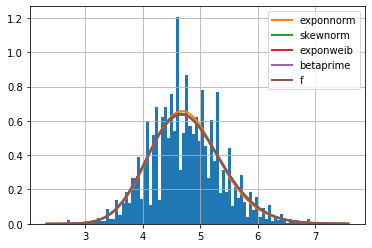

In [7]:
price_fitter = Fitter(df["log_price"])
price_fitter.fit(progress=True)
price_fitter.summary()

In [8]:
price_fitter.get_best()

{'exponnorm': {'K': 0.6903104277506913,
  'loc': 4.393797786089044,
  'scale': 0.5230441688120007}}

In [9]:
lowVals = stats.norm.rvs(loc=0.2, scale=0.1, size=1000, random_state=0)
lowVals = np.clip(lowVals, 0.001, 0.999)
highVals = stats.norm.rvs(loc=0.8, scale=0.1, size=1000, random_state=0)
highVals = np.clip(highVals, 0.001, 0.999)

In [10]:
K = 0.6903104277506913
loc = 4.393797786089044
scale = 0.5230441688120007

In [11]:
priceLow = stats.exponnorm.ppf(lowVals, K, loc, scale)
priceHigh = stats.exponnorm.ppf(highVals, K, loc, scale)

priceLowDf = sampleDf.assign(log_price=priceLow)
priceHighDf = sampleDf.assign(log_price=priceHigh)

priceLowPred = regressor.predict(priceLowDf)
priceHighPred = regressor.predict(priceHighDf)

stats.describe(priceLowPred), stats.describe(priceHighPred)

(DescribeResult(nobs=1000, minmax=(81.45, 98.46), mean=93.12926800396376, variance=7.147824849929808, skewness=-0.8865650566370326, kurtosis=1.1572368622860196),
 DescribeResult(nobs=1000, minmax=(78.42, 99.25), mean=94.67660866930918, variance=6.871383998732433, skewness=-1.5821634292951654, kurtosis=4.158054395629275))

## Correlation matrix

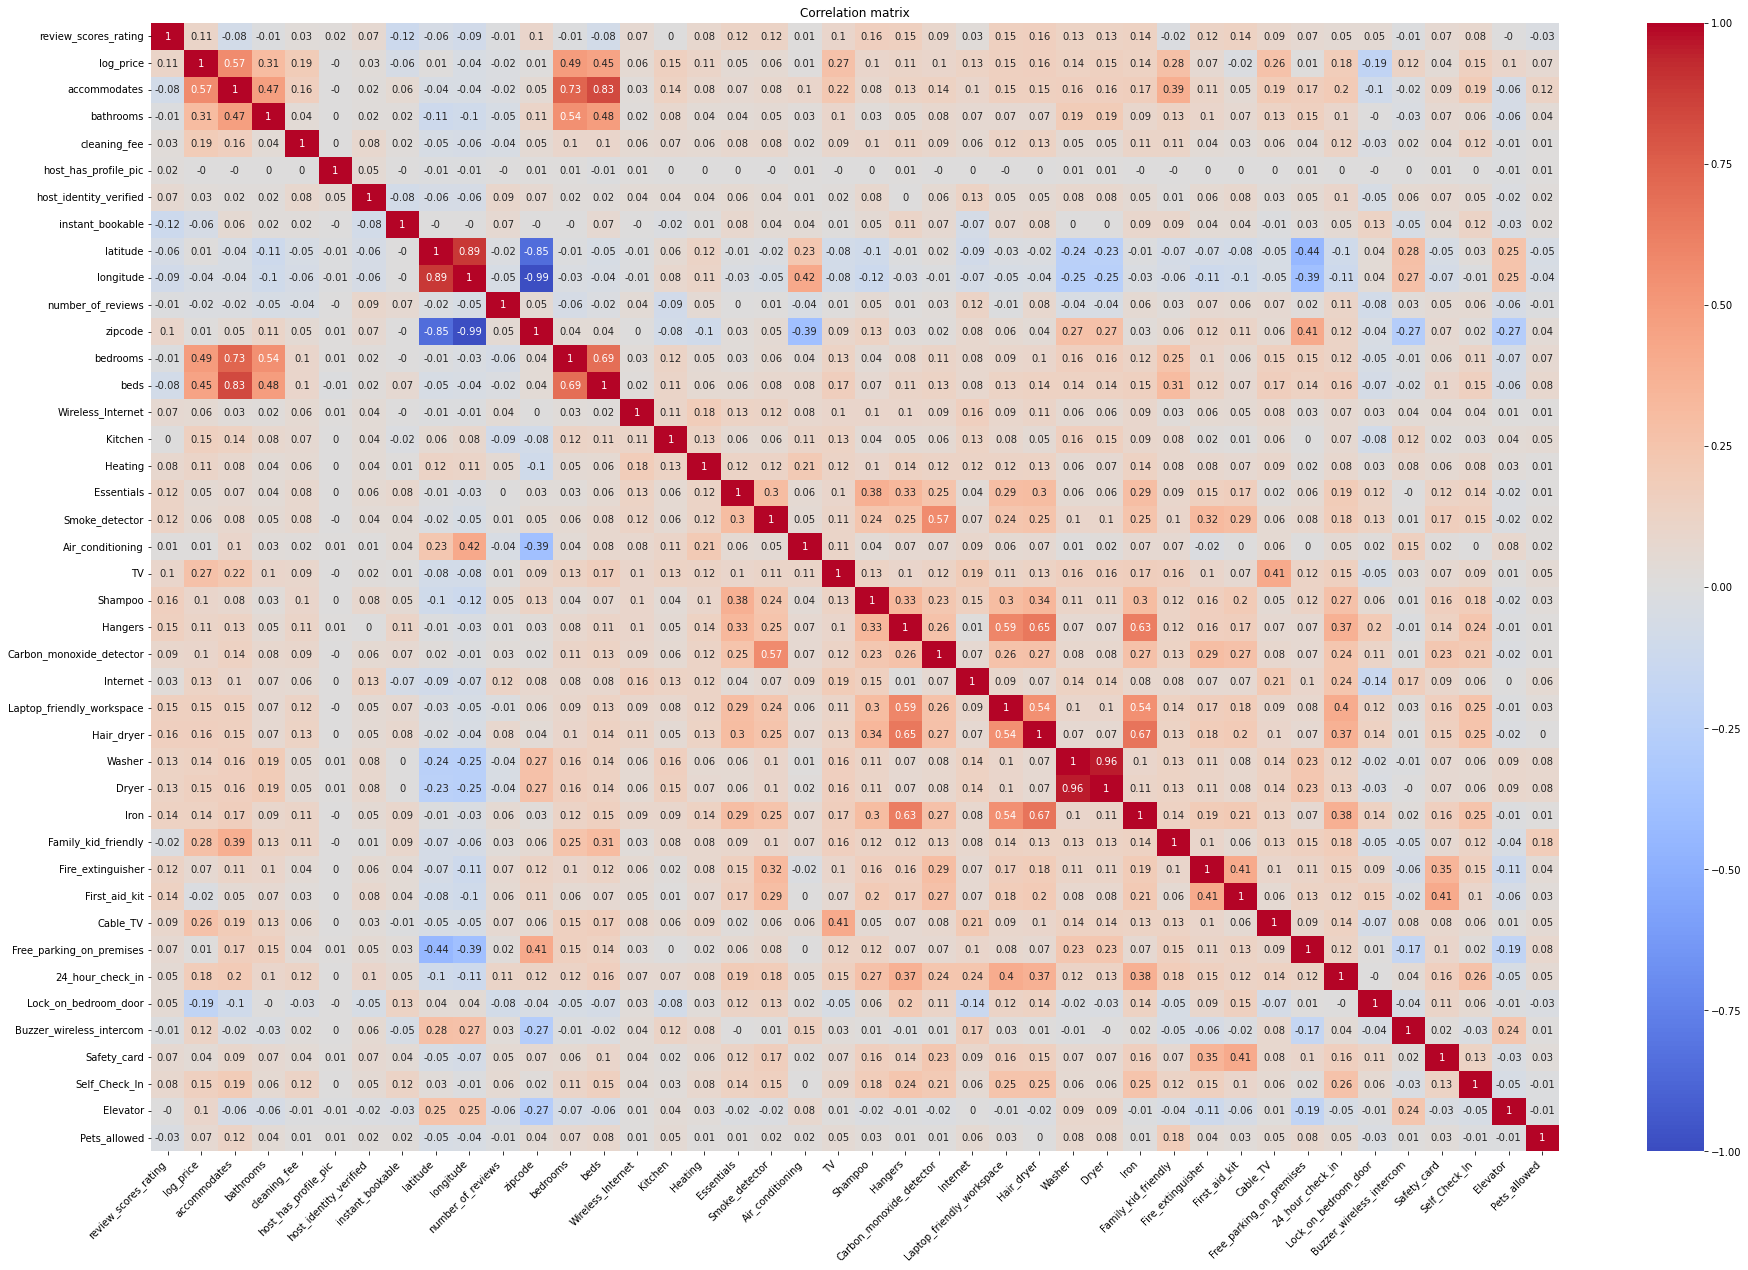

In [4]:
import matplotlib.pyplot as plt
import seaborn as sn

corr = pd.concat((y, X), axis=1).corr().round(2)
plt.figure()
plt.title("Correlation matrix")
sn.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap="coolwarm",
            xticklabels=True, yticklabels=True)
plt.xticks(rotation=45, ha="right")
plt.gcf().set_size_inches(27, 18)
plt.gcf().tight_layout(pad=2)